# House Price Prediction Model

In the ever-evolving landscape of real estate, accurately predicting house price is crucial for both buyers and sellers. Leveraging the power of machine learning, this case study delves into the development and evaluation of a house price prediction model. The goal is to create a robust and reliable tool that can assist in estimating property values based on various features.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

### Step 1: Setup

In [28]:
# Load the dataset
df = pd.read_csv("data/train.csv")
df.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
# Display basic information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [5]:
# Check for missing values
df.isnull().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

### Step 2: Data Pre-processing

In [6]:
Y = df['SalePrice']

In [7]:
# Select relevant features
features = df[['GrLivArea', 'BedroomAbvGr', 'FullBath', 'HalfBath', 'TotRmsAbvGrd']]
features.head()

,GrLivArea,BedroomAbvGr,FullBath,HalfBath,TotRmsAbvGrd
0,1710,3,2,1,8
1,1262,3,2,0,6
2,1786,3,2,1,6
3,1717,3,1,0,7
4,2198,4,2,1,9


In [8]:
features.isnull().sum()

GrLivArea       0
BedroomAbvGr    0
FullBath        0
HalfBath        0
TotRmsAbvGrd    0
dtype: int64

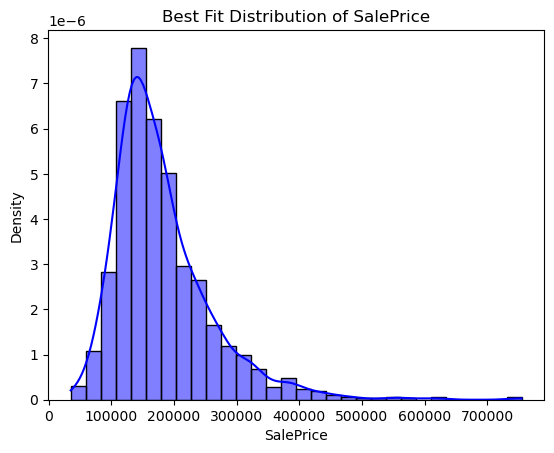

In [9]:
# Visualize distribution before log transformation
plt.title('Best Fit Distribution of SalePrice')
sns.histplot(Y, kde=True, stat='density', color='blue', bins=30)
plt.show()

The data displays a leftward skew, indicating that the majority of houses have lower sale prices, with only a small number of houses having notably higher sale prices.

In [10]:
# Perform log transformation on the target variable
df['y_log'] = np.log1p(df['SalePrice'])

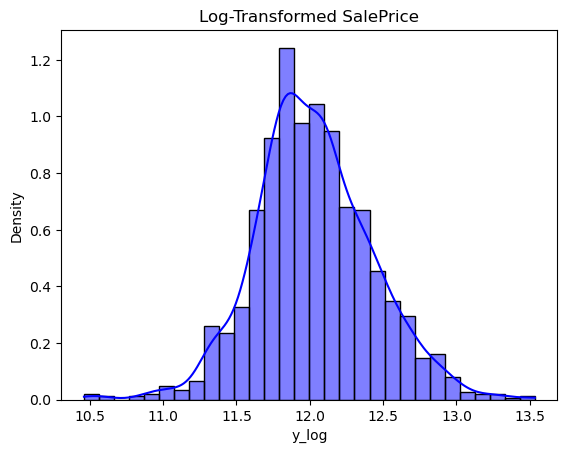

In [11]:
# Visualize distribution after log transformation
plt.title('Log-Transformed SalePrice')
sns.histplot(df['y_log'], kde=True, stat='density', color='blue', bins=30)
plt.show()

In [12]:
# List of features to be analyzed
features = ['GrLivArea', 'BedroomAbvGr', 'FullBath', 'HalfBath', 'TotRmsAbvGrd']

# Function to check normality using Shapiro-Wilk test
def is_not_normal(data):
    return stats.shapiro(data.fillna(0))[1] < 0.01

# Create a DataFrame with selected features and apply the normality test
normal = pd.DataFrame(df[features].apply(is_not_normal))

# Check if any feature is not normally distributed
result = normal.all(axis=1)
result.all()

True

Since the result is True, it means the normality test has passed

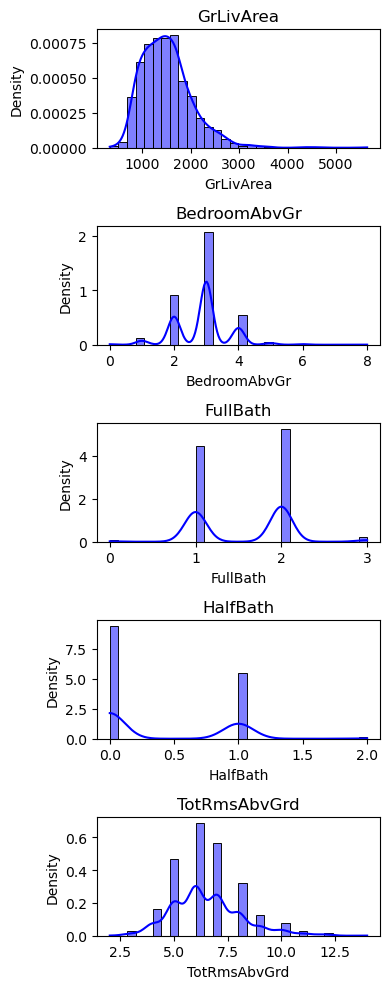

In [13]:
fig, axes = plt.subplots(nrows=len(features), ncols=1, figsize=(4, 2 * len(features)))

# Plot histograms for each feature
for i, feature in enumerate(features):
    sns.histplot(df[feature], kde=True, stat='density', color='blue', bins=30, ax=axes[i])
    axes[i].set_title(feature)

plt.tight_layout()
plt.show()

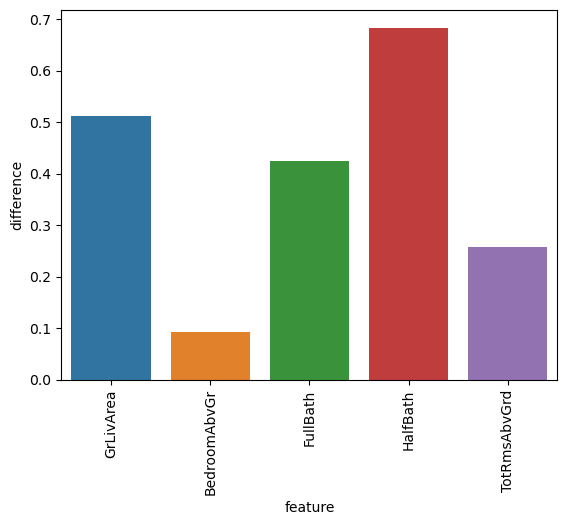

In [14]:
# Filter data into two groups based on SalePrice
low_price_group = df[df['SalePrice'] < 200000]
high_price_group = df[df['SalePrice'] >= 200000]

# Calculate the relative difference in mean for each feature
difference_df = pd.DataFrame()
difference_df['feature'] = features
difference_df['difference'] = [(high_price_group[f].fillna(0).mean() - low_price_group[f].fillna(0).mean()) /
                                (low_price_group[f].fillna(0).mean()) for f in features]

# Plot the differences using a bar plot
sns.barplot(data=difference_df, x='feature', y='difference')

# Rotate x-axis labels for better readability
x = plt.xticks(rotation=90)

# Display the plot
plt.show()

In this context, every relative mean difference is positive, suggesting that, on average, the chosen features exhibit higher mean values in the 'pricey' subset (with 'SalePrice' greater than or equal to 200,000) when contrasted with the 'standard' subset (with 'SalePrice' less than 200,000).

In [15]:
# Train-test split
features = df[['GrLivArea', 'BedroomAbvGr', 'FullBath', 'HalfBath', 'TotRmsAbvGrd']]
target = df['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

### Step 3: Build and Train Model

In [16]:
# Train Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

### Step 4: Evaluation

In [17]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}\nRoot Mean Squared Error: {rmse}\nR2-squared: {r2}')

Mean Squared Error: 2809126045.9448595
Root Mean Squared Error: 53001.189099348136
R2-squared: 0.6337670693441046


The previous example lacks Feature Engineering and utilizes the raw form without any transformations or modifications.

In [18]:
# Extracting features and target variable
features = df[['GrLivArea', 'BedroomAbvGr', 'FullBath', 'HalfBath', 'TotRmsAbvGrd']]
target = df['y_log']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Creating a Linear Regression model
model = LinearRegression()

# Training the model with the training data
model.fit(X_train, y_train)

# Making predictions on the test set
y_pred = model.predict(X_test)

# Calculating Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculating Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Calculating R-squared (R2) score
r2 = r2_score(y_test, y_pred)

# Displaying the evaluation metrics
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R2-squared: {r2}')

Mean Squared Error: 0.07208942066526795
Root Mean Squared Error: 0.2684947311685426
R2-squared: 0.6136914486636759


This version is the one we employ post log transformation, addressing the left-skewed distribution observed in both the features and the target variable.

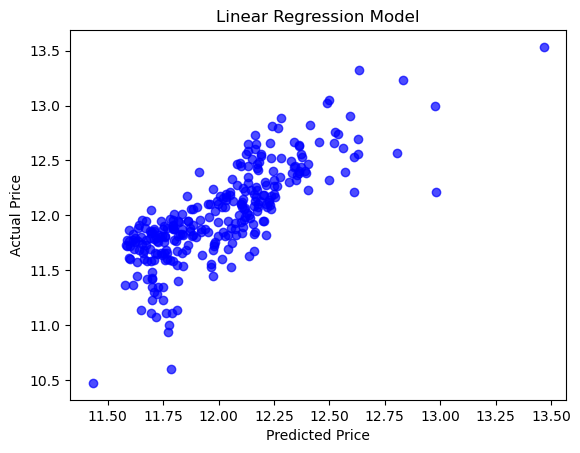

In [19]:
# Creating a scatter plot to visualize predicted vs. actual prices
plt.scatter(y_pred, y_test, alpha=0.7, color='b')
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Linear Regression Model')
plt.show()

In [20]:
# Load test dataset
test_df = pd.read_csv('data/test.csv')

In [21]:
# Apply log transformation to test features
# test_df['GrLivArea_log'] = np.log1p(test_df['GrLivArea'])
test_features = test_df[['GrLivArea', 'BedroomAbvGr', 'FullBath', 'HalfBath', 'TotRmsAbvGrd']]

In [22]:
# Make predictions on test set
test_predictions = model.predict(test_features)

In the training phase, we applied a logarithmic transformation to the target variable. Subsequently, the linear regression model was trained using both the features and the logarithmically transformed target variable. When making predictions on the test set, the results are expressed in the logarithmic scale. To convert these predictions back to the original scale (dollars), we can apply the inverse of the logarithmic transformation.

In [23]:
# Convert predictions back to original scale
predictions = np.exp(test_predictions)
predictions

array([121561.25678653, 140378.35588731, 195936.84514502, ...,
       112880.95300604, 112597.46324789, 232553.40672642])

In [24]:
# Create submission DataFrame
submission = pd.DataFrame({'SalePrice': predictions})

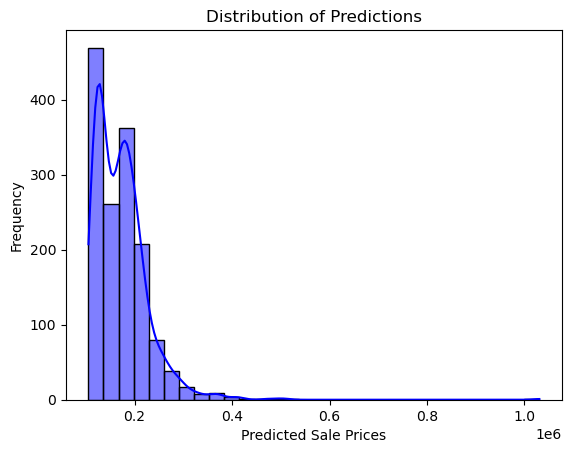

In [25]:
# Visualize distribution of predictions
sns.histplot(predictions, kde=True, color='blue', bins=30)
plt.title('Distribution of Predictions')
plt.xlabel('Predicted Sale Prices')
plt.ylabel('Frequency')
plt.show()